# Part 4 - Project expansion

The notebook below integrates South Dakota's annual financial reports which contain information on wildfire acreage and the amount spent yearly on wildfire suppression. There are two overarching goals of this notebook:

1. Using my computed smoke metric, predict the yearly wildfire suppression budget for the next 25 years.

2. Using South Dakota's internal reportings on wildfire acreage, predict the yearly wildfire suppresion budget for the next 25 years.

The imports below are standard plotting and modeling imports. The lowess function is used a smooth function designed to extract the general trend from data. I use it when predicting the yearly wildfire suppression budget from South Dakota's wildfire reports. 

In [1]:
# standard imports used for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

The function below, yearly_smoke_estimate, calculates an annual smoke estimate for a given city based on wildfire data. It filters fires within 650 miles of the city, groups the data by year, and computes the total smoke impact for each year. A computed smoke metric is then derived by multiplying the total smoke impact by a default scale factor of 5000. The function returns a dataframe with the year, total smoke impact, and computed smoke metric.

In [2]:
def yearly_smoke_estimate(wildfire_df, city_name, smoke_scale_factor = 5000):
    """
    Takes in a dataframe containing information about wildfires 
    and a city name to estimate yearly smoke impact.

    Parameters:
        - wildfire_df: DataFrame containing wildfire information. 
                       Must include columns for "Fire_Year", 
                       "smoke_impact", and "average_distance_from_<city>".
        - city_name: Name of the city to filter wildfires by distance.
        - smoke_scale_factor: Scaling factor for smoke impact 
                              (default is 5000).

    Returns:
        A DataFrame with the following columns:
        - "Year": The year of the wildfire.
        - "total_smoke_impact": Total smoke impact for wildfires within 
                                650 miles of the city.
        - "Computed smoke metric": Scaled smoke impact based on the 
                                   provided smoke_scale_factor.
    """

    wildfire_df = wildfire_df[wildfire_df[f"average_distance_from_{city_name}"] <= 650]

    # Group by "year" and sum "smoke_impact"
    smoke_impact_by_year = wildfire_df.groupby("Fire_Year", as_index=False)["smoke_impact"].sum()

    # Renames the column for clarity
    smoke_impact_by_year.rename(columns={"smoke_impact": "total_smoke_impact"}, inplace=True)
    smoke_impact_by_year["Computed smoke metric"] = smoke_impact_by_year["total_smoke_impact"] * smoke_scale_factor
    smoke_impact_by_year.rename(columns={"Fire_Year": "Year"}, inplace=True)
    return smoke_impact_by_year


The function adjust_for_inflation adjusts a budget dataframe for inflation using Consumer Price Index (CPI) data. It converts the "Amount spent" in the dataset to a specific year's dollar value (e.g., 2023 dollars) based on CPI. The function merges the budget dataframe with the CPI data on the "Year" column and calculates the adjusted amount using the CPI for the desired year. The output is a dataframe with the original and inflation-adjusted budget data.

In [3]:
def adjust_for_inflation(budget_dataframe, cpi_data, year_to_use):
    """
    Adjusts a budget dataframe for inflation using CPI data to convert
    amounts into a specific year's dollar value.

    Parameters:
        - budget_dataframe: DataFrame containing budget information, 
                            must include columns for "Year" and 
                            "Amount spent (in thousands of USD)".
        - cpi_data: DataFrame containing CPI information, must include
                    columns for "Year" and "CPI".
        - year_to_use: The year to which the budget values will be 
                       adjusted (e.g., 2023).

    Returns:
        A DataFrame with the original budget information and an 
        additional column:
        - "Amount spent (2023 dollars)": The inflation-adjusted 
                                         budget amount.
    """

    # Merge 'wildfire_budget_info' with 'yearly_cpi' on the 'Year' column
    merged_df = pd.merge(budget_dataframe, cpi_data, on="Year", how="left")

    # Get the CPI value for 2023 from 'cpi_data'
    cpi_2023 = cpi_data.loc[cpi_data['Year'] == year_to_use, 'CPI'].iloc[0]


    # Adjust the 'Amount spent' to 2023 dollars using the formula
    merged_df['Amount spent (2023 dollars)'] = merged_df['Amount spent (in thousands of USD)'] * (cpi_2023 / merged_df['CPI'])
    return merged_df

The function smoke_and_budget_merge combines two dataframes, one containing smoke metrics and the other containing budget and wildfire acreage data, by merging them on the "Year" column. It simplifies each dataframe to include only the relevant columns before merging and returns a combined dataframe with smoke metrics, inflation-adjusted budget values, and wildfire acreage for each year.

In [4]:
def smoke_and_budget_merge(smoke_dataframe, budget_dataframe):
    """
    Merges smoke metric data with budget and wildfire acreage data 
    by year.

    Parameters:
        - smoke_dataframe: DataFrame containing smoke metric 
                           information, must include columns for 
                           "Year" and "Computed smoke metric".
        - budget_dataframe: DataFrame containing budget and acreage 
                            information, must include columns for 
                            "Year", "Amount spent (2023 dollars)", 
                            and "Wildfire acreage".

    Returns:
        A merged DataFrame 
    """

    smoke_simplified = smoke_dataframe[["Year", "Computed smoke metric"]].copy()
    budget_simplified = budget_dataframe[["Year", "Amount spent (2023 dollars)", "Wildfire acreage"]].copy()
    result = pd.merge(smoke_simplified, budget_simplified, on='Year', how='inner')
    return result


The function add_shifts adds two new columns to a dataframe representing shifted values of a specified column. The first new column contains the value shifted by size rows down (Lag+1), and the second new column contains the value shifted by size rows up (Lag-1). I use this because the financial reports are on the fiscal year (July-June), while the smoke metric is on the normal year. Therefore, I need to see which yearly financial report best aligns with the smoke data. (E.g. if a shift of -1 is best, this is indicates a 2025 budget is more representative of the second half of 2024 than the first half of 2025)

In [5]:
def add_shifts(dataframe, column, size):
    """
    Adds two new columns to the dataframe representing shifted values 
    of a specified column.

    Parameters:
        - dataframe: DataFrame containing the column to shift.
        - column: The name of the column to shift.
        - size: The number of rows to shift the column values.

    Returns:
        A DataFrame with a shifted column
    """

    # Create Lag+1 (next row) and Lag-1 (previous row) columns
    dataframe[f'{column}-1'] = dataframe[column].shift(-size)  # Shift down
    dataframe[f'{column}+1'] = dataframe[column].shift(size)   # Shift up
    return dataframe

The function plot_smoke_metric_wildfire_acreage generates a dual-axis line plot to compare a smoke metric with wildfire acreage data. The primary y-axis displays the chosen smoke metric, while the secondary y-axis shows the wildfire acreage and its shifted versions (Lag-1 and Lag+1). The plot allows visualization of which shifted column (in my case annual wildfire suppresion budget), has the best correlation with my smoke metric. 

In [6]:
def plot_smoke_metric_wildfire_acreage(dataframe, metric, shifted_column): 
    """
    Creates a dual-axis line plot comparing a smoke metric with wildfire acreage.

    Parameters:
        - dataframe: DataFrame containing columns for 'Year', the specified smoke metric, 
                     and the shifted wildfire acreage data.
        - metric: The name of the column representing the smoke metric to plot.
        - shifted_column: The name of the column representing wildfire acreage. 
                          The function will plot this column along with its shifted versions 
                          (Lag-1 and Lag+1).

    Returns:
        A dual-axis plot:
        - The first y-axis shows the smoke metric values.
        - The second y-axis shows the wildfire acreage values and its shifted versions 
          (Lag-1, Lag+1).
        - Includes a title, axis labels, rotated x-tick labels, and a legend for both axes.
    """
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8), dpi=300)

    # Plot total_smoke_adj on the first y-axis
    ax1.plot(dataframe['Year'], dataframe[metric], color='blue', marker='o', label=f'{metric}', linestyle='-', linewidth=2)
    ax1.set_xlabel('Year', fontsize=16)
    ax1.set_ylabel(metric, color='blue', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis ticks
    # Ensure the x-axis shows years as integers
    ax1.set_xticks(dataframe['Year'].astype(int))  # Set the x-ticks to integer years
    ax1.set_xticklabels(dataframe['Year'].astype(int), rotation=45)  # Set the x-tick labels and rotate them for better visibility


    # Create a second y-axis for acreage
    ax2 = ax1.twinx()
    ax2.plot(dataframe['Year'], dataframe[shifted_column], color='green', marker='s', label=f'{shifted_column}', linestyle='--', linewidth=2)
    ax2.plot(dataframe['Year'], dataframe[f'{shifted_column}+1'], color='orange', marker='^', label=f'{shifted_column}+1', linestyle='--', linewidth=2)
    ax2.plot(dataframe['Year'], dataframe[f'{shifted_column}-1'], color='red', marker='d', label=f'{shifted_column}-1', linestyle='--', linewidth=2)

    # Set the y-axis label for the second axis
    ax2.set_ylabel(f'{shifted_column}', color='black', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=14)

    # Title and legend
    plt.title(f'{metric} compared to state reported {shifted_column}', fontsize=18)
    fig.tight_layout()

    # Add legend for both axes
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, fontsize=14)

    # Show the plot
    plt.show()

The function apply_shift computes the correlation between a specified smoke metric and shifted wildfire acreage data to identify the best shift for optimal correlation. After determining the optimal shift, the function creates new columns with the shifted data and optionally drops columns with opposite shifts. The goal is to find the shift that aligns the best with the smoke metric for further analysis. In my case, a shift of -1 year to each financial report had the best correlation. Therefore I use that going forward.

In [7]:
def apply_shift(dataframe, metric, shifted_column, column_to_shift, drop = True):
    """
    Calculates the optimal shift for a specified column based on its correlation with a given metric, 
    and applies the shift to the dataframe.

    Parameters:
        - dataframe: DataFrame containing the smoke metric and shifted wildfire acreage data.
        - metric: The name of the column representing the smoke metric.
        - shifted_column: The name of the column representing the wildfire acreage data to shift.
        - column_to_shift: The column name that will be shifted according to the optimal shift.
        - drop: Whether to drop the columns with the opposite of the optimal shift (default is True).

    Returns:
        - A DataFrame with the optimal shift applied to the specified column, 
        and the opposite shift dropped if drop is True.
    """
    
    # Calculate correlation between total_smoke_adj and the monetary columns
    correlations = dataframe[[f'{metric}', 
                        f'{shifted_column}', 
                        f'{shifted_column}+1', 
                        f'{shifted_column}-1']].corr()

    # Extract the correlations between total_smoke_adj and the three monetary columns
    correlation_summary = correlations[f'{metric}'][1:]

    # Find the monetary data with the best correlation
    best_correlation_column = correlation_summary.idxmax()
    optimal_shift = int(best_correlation_column[-2:])
    best_correlation_value = correlation_summary.max()

    print(f"The {shifted_column} with the best correlation with {metric} is '{best_correlation_column}' with a correlation of {best_correlation_value:.2f}")

    dataframe[f'{column_to_shift}{optimal_shift}'] = dataframe[f'{column_to_shift}'].shift(optimal_shift)
    dataframe[f'{column_to_shift}+{-optimal_shift}'] = dataframe[f'{column_to_shift}'].shift(-optimal_shift)

    if drop:
        # Drop the column corresponding to the opposite of the optimal shift
        unnecessary_shifted_column_1 = f'{shifted_column}+{-optimal_shift}'
        unnecessary_shifted_column_2 = f'{column_to_shift}+{-optimal_shift}'
        if unnecessary_shifted_column_1 in dataframe.columns:
            dataframe.drop(columns=[unnecessary_shifted_column_1], inplace=True)
        if unnecessary_shifted_column_2 in dataframe.columns:
            dataframe.drop(columns=[unnecessary_shifted_column_2], inplace=True)
    return dataframe


The function plot_smoke_metric_and_budget creates a dual-axis plot to compare a smoke metric with the state budget for wildfire suppression over time. The primary y-axis shows the state budget (shifted backward by one year), while the secondary y-axis displays the smoke metric. The plot allows for a visual comparison of how the smoke metric correlates with the state budget over the years, including axis labels, a title, and a combined legend. I use this to plot the now shifted wildfire suppresion budget against my computed smoke metric

In [8]:
def plot_smoke_metric_and_budget(dataframe, metric, budget_column):
    """
    Creates a dual-axis plot comparing a smoke metric with the state budget for wildfire suppression.

    Parameters:
        - dataframe: DataFrame containing columns for 'Year', the specified smoke metric, 
                    and the state budget values.
        - metric: The name of the column representing the smoke metric.
        - budget_column: The name of the column representing the state budget, 
                        which is plotted with a one-year backward shift.

    Returns:
        - A dual-axis plot:
            - The first y-axis displays the state budget (shifted backward by one year).
            - The second y-axis displays the smoke metric.
            - Includes a title, axis labels, rotated x-tick labels, and a legend for both axes.
    """
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8), dpi=300)

    # Plot monetary values on the first y-axis (left axis)
    ax1.plot(dataframe['Year'], dataframe[f'{budget_column}'], color='green', marker='s', label='State budget (one year shifted backward)', linestyle='--', linewidth=2)

    # Set the y-axis label for monetary values
    ax1.set_xlabel('Year', fontsize=16)
    ax1.set_ylabel('State budget (in thousands of USD)', color='green', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    # Ensure the x-axis shows years as integers
    ax1.set_xticks(dataframe['Year'].astype(int))  # Set the x-ticks to integer years
    ax1.set_xticklabels(dataframe['Year'].astype(int), rotation=45)  # Set the x-tick labels and rotate them for better visibility



    # Create a second y-axis for wildfire acreage
    ax2 = ax1.twinx()
    ax2.plot(dataframe['Year'], dataframe[f'{metric}'], color='orange', marker='d', label=f'{metric}', linestyle='-', linewidth=2)

    # Set the y-axis label for acreage
    ax2.set_ylabel(f'{metric}', color='black', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=14)

    # Title and legend
    plt.title(f'{metric} compared to wildfire suppression budget (in thousands of USD, adjusted for inflation)', fontsize=18)
    fig.tight_layout()

    # Add legend for both axes
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, fontsize=14)

    # Show the plot
    plt.show()

The function make_wildfire_year_model fits a linear regression model to forecast the smoke impact for future years based on past data. It takes a specific smoke metric, prepares the data for modeling, and then predicts the future values within a given range of years. The function also computes 95% confidence intervals for the predictions. Optionally, the model parameters can be printed for review.

In [9]:
def make_wildfire_year_model(dataframe, metric, start_pred_year, end_pred_year, print_params):
        """
        Fits a linear regression model to predict future smoke impact based on a given smoke metric, 
        and provides predictions with confidence intervals.

        Parameters:
        - dataframe: DataFrame containing historical data for 'Year' and the specified metric.
        - metric: The name of the column representing the smoke metric to predict.
        - start_pred_year: The starting year for the prediction.
        - end_pred_year: The ending year for the prediction.
        - print_params: Whether to print the model parameters (default is False).

        Returns:
        - predictions: A series of predicted values for the specified metric for the future years.
        - predictions_summary_frame: A summary frame containing the prediction along with 95% confidence intervals.
        - future_years: A DataFrame of the years for which predictions were made.
        """
        # Step 2: Prepare the data for modeling
        X = dataframe["Year"]
        y = dataframe[f"{metric}"]
        # Adding a constant for the intercept
        X = sm.add_constant(X)

        # Step 3: Fit a linear regression model
        model = sm.OLS(y, X).fit()

        # Step 4: Create a future DataFrame for prediction
        future_years = pd.DataFrame({"Year": np.arange(start_pred_year, end_pred_year+1)})
        future_X = sm.add_constant(future_years)

        # Step 5: Predict future smoke impact
        predictions = model.predict(future_X)

        # Calculate confidence intervals
        predictions_summary_frame = model.get_prediction(future_X).summary_frame(alpha=0.05)  # 95% CI

        if print_params:
                print(f"The parameters for the {metric} model are: \n", model.params, "\n")
                print()
        return predictions, predictions_summary_frame, future_years
    

The function below is similar to the one used in smoke_impact_model_building.ipynb. 

The function plot_smoke_model visualizes both historical and predicted smoke impact values. It uses a linear regression model to forecast future smoke impact based on past data, and displays the predicted values along with 95% confidence intervals. The plot includes historical data, predictions, and the confidence interval for future estimates, allowing for easy comparison of past and predicted trends over time.

In [10]:
def plot_smoke_model(df, metric, start_hist_year, start_pred_year, end_pred_year, print_params=True):
    """
    Plots the historical and predicted smoke impact values, with a 95% confidence interval.

    Parameters:
        - df: DataFrame containing the wildfire data with columns for 'Year' and the specified smoke metric.
        - metric: The name of the column representing the smoke metric to plot.
        - start_hist_year: The starting year of the historical data.
        - start_pred_year: The year to start predicting the smoke estimate.
        - end_pred_year: The year to end predicting the smoke estimate.
        - print_params: Whether to print the model parameters (default is True).

    Returns:
        - A plot showing:
            - Historical smoke data for the specified metric.
            - Predicted future smoke data with a linear regression model.
            - A shaded area representing the 95% confidence interval for the predictions.
    """

    predictions, predictions_summary_frame, future_years = make_wildfire_year_model(df, metric, start_pred_year, end_pred_year, print_params)

    # Step 6: Plot the historical and predicted values
    plt.figure(figsize=(14, 8), dpi=300)  # Larger plot size and higher resolution (300 dpi)

    # Historical Data
    plt.plot(df["Year"], df[f"{metric}"], marker='o', label='Smoke metric (historical)', color='b', linewidth=2)

    # Predicted Data
    plt.plot(future_years["Year"], predictions, marker='o', label='Smoke metric (predicted)', color='orange', linewidth=2)

    # Confidence Intervals
    plt.fill_between(future_years["Year"],
                    predictions_summary_frame['obs_ci_lower'],
                    predictions_summary_frame['obs_ci_upper'],
                    color='gray', alpha=0.5, label='95% Confidence Interval')

    # Add labels and title with increased font size
    plt.title('Historical and Predicted Smoke Impact (1961 - 2046)', fontsize=20)  # Increase title font size
    plt.xlabel('Year', fontsize=18)  # Increase x-axis label font size
    plt.ylabel('Total Smoke Adjusted', fontsize=18)  # Increase y-axis label font size

    # Increase the font size for tick labels
    plt.xticks(np.arange(start_hist_year, end_pred_year+4, 5), fontsize=16)  # Larger x-tick labels
    plt.yticks(fontsize=16)  # Larger y-tick labels

    # Add legend with larger font size
    plt.legend(fontsize=16)

    # Show grid for better readability
    plt.grid(True)

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Display the plot
    plt.show()


The function make_budget_model builds a linear regression model to predict the budget based on the smoke metric. It fits the model using historical data for smoke and budget, and then uses the model to forecast future budget values for a given set of future smoke predictions. The model parameters are optionally printed for review. It's use as an internal model builder in the plot_budget_model function below.

In [11]:
def make_budget_model(dataframe, smoke_name, budget_name, prediction_years, print_params):
    """
    Creates a linear regression model to predict the budget based on a given smoke metric.

    Parameters:
        - dataframe: DataFrame containing the smoke and budget data.
        - smoke_name: The name of the column representing the smoke metric.
        - budget_name: The name of the column representing the budget to predict.
        - prediction_years: A DataFrame or array of future years to predict the budget for.
        - print_params: Whether to print the model parameters (default is True).

    Returns:
        - predictions_budget: The predicted budget values based on the forecasted smoke metric.
    """
    
    dataframe_clean = dataframe.dropna(subset=[f"{smoke_name}", f"{budget_name}"])
    # Independent and dependent variables
    X_smoke = dataframe_clean[f"{smoke_name}"]
    y_budget = dataframe_clean[f"{budget_name}"]

    # Add a constant for the intercept
    X_smoke = sm.add_constant(X_smoke)

    # Fit a linear regression model
    model_smoke = sm.OLS(y_budget, X_smoke).fit()

    # Future DataFrame for total_smoke_adj
    future_smoke = pd.DataFrame({"total_smoke_adj": prediction_years})
    future_X_smoke = sm.add_constant(future_smoke)

    # Predictions for budget-1 based on total_smoke_adj predictions
    predictions_budget = model_smoke.predict(future_X_smoke)

    if print_params:
        print(f"The parameters for the {budget_name} model are: \n", model_smoke.params)
        print()
    return predictions_budget



The function plot_budget_model creates a visualization comparing historical and predicted values for both a smoke metric and wildfire suppression budget. It plots the historical smoke and budget data, forecasts future values using linear regression models, and displays 95% confidence intervals for the predicted smoke values. The function overlays both the historical and predicted data on dual y-axes for easier comparison.

In [12]:
def plot_budget_model(historical_smoke_dataframe, dataframe, smoke_metric, budget_metric, start_pred_year, end_pred_year, print_params = True):
    """
    Plots historical and predicted values for a given smoke metric and wildfire suppression budget.

    Parameters:
        - historical_smoke_dataframe: DataFrame containing historical smoke metric data.
        - dataframe: DataFrame containing both the historical smoke and budget data.
        - smoke_metric: The name of the column representing the smoke metric.
        - budget_metric: The name of the column representing the wildfire suppression budget.
        - start_pred_year: The starting year for the smoke prediction.
        - end_pred_year: The ending year for the smoke prediction.
        - print_params: Whether to print model parameters for the smoke and budget models (default is True).

    Returns:
        - A plot with historical and predicted values for both the smoke metric and wildfire suppression budget. 
        The plot also includes a 95% confidence interval for the predicted smoke values.
    """
    
    predictions, prediction_summary_frame, future_years = make_wildfire_year_model(historical_smoke_dataframe, smoke_metric, start_pred_year, end_pred_year, print_params)
    predictions_budget = make_budget_model(dataframe, smoke_metric, budget_metric, predictions, print_params)
    # predictions is prediction_years
    # Start by making a smoke model
    # Then train a budget model on the smoke
    # Then plot both models

    # Step 1: Plot the historical data
    fig, ax1 = plt.subplots(figsize=(14, 8), dpi=300)  # Set up the plot with a larger size and higher resolution

    # Historical Data for total_smoke_adj (on the left y-axis)
    ax1.plot(dataframe["Year"], dataframe[f"{smoke_metric}"], marker='o', label=f'{smoke_metric} (historical)', color='b', linewidth=2)
    ax1.set_xlabel('Year', fontsize=18)
    ax1.set_ylabel(f'{smoke_metric}', fontsize=18, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(np.arange(dataframe["Year"].min(), future_years["Year"].max() + 1, 5))
    ax1.set_xticklabels(np.arange(dataframe["Year"].min(), future_years["Year"].max() + 1, 5), fontsize=16)
    ax1.tick_params(axis='x', labelsize=16)

    # Step 2: Create the second y-axis for budget-1 values
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

    # Plot the historical data for budget-1 (on the right y-axis)
    ax2.plot(dataframe["Year"], dataframe[f"{budget_metric}"], marker='o', label='Shifted state budget (historical)', color='g', linewidth=2)
    ax2.set_ylabel('Wildfire suppression budget (in thousands of 2023 USD)', fontsize=18, color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Step 3: Plot the predictions for future years
    # Plot total_smoke_adj predictions (future) on the left y-axis
    ax1.plot(future_years["Year"], predictions, marker='o', label=f'{smoke_metric} (predicted)', color='orange', linestyle='--', linewidth=2)
    ax2.plot(future_years["Year"], predictions_budget, marker='o', label='Shifted state budget (predicted)', color='purple', linestyle='--', linewidth=2)

    # Step 4: Add confidence intervals for total_smoke_adj only
    # Confidence interval for total_smoke_adj
    ax1.fill_between(future_years["Year"], 
                    prediction_summary_frame['obs_ci_lower'], 
                    prediction_summary_frame['obs_ci_upper'], 
                    color='gray', alpha=0.5, label='95% CI (Smoke metric)')

    # Step 5: Add labels, title, and legend
    ax1.set_title('Historical and Predicted Smoke and Wildfire Suppression Budget (2001 - 2046)', fontsize=20)
    ax1.legend(loc='upper left', fontsize=16)
    ax2.legend(loc='upper right', fontsize=16)

    # Step 6: Display grid and layout
    ax1.grid(True)
    plt.tight_layout()  # Prevent clipping of labels
    plt.show()
    


The function plot_acreage_and_budget generates a plot that compares wildfire acreage data and the state budget over the years. The plot uses two y-axes: the left axis shows the wildfire acreage, and the right axis displays the state budget adjusted for inflation. This visualization allows for easy comparison of the trends in both datasets over time, with clear legends and appropriate labels for each axis.

In [13]:
def plot_acreage_and_budget(dataframe, acreage, budget):
    """
    Plots the comparison of wildfire acreage and the state budget for wildfire suppression over the years.

    Parameters:
        - dataframe: DataFrame containing the wildfire acreage and budget data.
        - acreage: The name of the column representing the wildfire acreage data.
        - budget: The name of the column representing the state budget data for wildfire suppression.

    Returns:
        - A plot showing the historical trends of wildfire acreage (on the left y-axis) and state budget (on the right y-axis), with legends and proper labeling.
    """
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8), dpi=300)

    # Plot "Wildfire acreage" on the first y-axis (Left)
    ax1.plot(dataframe['Year'], dataframe[f'{acreage}'], color='orange', marker='s', label=f'{acreage}', linestyle='-', linewidth=2)
    ax1.set_xlabel('Year', fontsize=16)
    ax1.set_ylabel(f'{acreage}', color='black', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis ticks
    ax1.set_xticks(dataframe['Year'].astype(int))  # Set the x-ticks to integer years
    ax1.set_xticklabels(dataframe['Year'].astype(int), rotation=45)  # Rotate the x-tick labels for better visibility

    # Create a second y-axis for the other metrics (Right)
    ax2 = ax1.twinx()

    ax2.plot(dataframe['Year'], dataframe[f'{budget}'], color='green', marker='^', label=f'{budget}', linestyle='-.', linewidth=2)

    # Set the y-axis label for the second axis
    ax2.set_ylabel('State budget (in thousands of USD)', color='green', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)

    # Title and layout adjustments
    plt.title('Wildfire Acreage and State Budget from 2001 to 2020 (adjusted for inflation)', fontsize=18)
    fig.tight_layout()

    # Add legend for both axes
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, fontsize=14)

    # Show the plot
    plt.show()

The function below, model_future_acreage_and_budget, is slightly modified version of the make_budget_model function above. I incorporated LOWESS smoothing in order to capture the predicted decrease down to 0 wildfire acres burned. Obviously, this is likely not realistic (explained more in the paper), but the smoothing avoided a sharp decrease to 0.

The function model_future_acreage_and_budget forecasts future wildfire acreage and the corresponding state budget for wildfire suppression. It follows these key steps:

1. Prediction of Future Acreage: Uses the provided wildfire data to model future wildfire acreage predictions (smoothed using LOWESS for better trend representation).

2. Prediction of Budget: Fits an OLS regression model to predict the future state budget based on the predicted wildfire acreage.
    
3. Clipping of Negative Predictions: Ensures that no negative acreage predictions are made by setting any negative values to zero.
    
4. Return Values: The function returns the predicted future wildfire acreage, the summary frame for predictions, predicted future budget, and the corresponding future years.

In [14]:
def model_future_acreage_and_budget(dataframe, wildfire_metric, budget_metric, start_pred_year, end_pred_year, print_params):
    """
    Models and predicts future wildfire acreage and corresponding state budget for wildfire suppression.

    Parameters:
        - dataframe: DataFrame containing historical wildfire acreage and budget data.
        - wildfire_metric: The column name representing the wildfire acreage data.
        - budget_metric: The column name representing the state budget data for wildfire suppression.
        - start_pred_year: The starting year for the prediction period.
        - end_pred_year: The ending year for the prediction period.
        - print_params: Boolean flag indicating whether to print the model parameters.

    Returns:
        - future_wildfire_predictions: The predicted wildfire acreage for future years.
        - predictions_summary_frame: The summary frame containing confidence intervals for the predictions.
        - future_spent_predictions: The predicted state budget for future years based on the wildfire acreage predictions.
        - future_years: The future years for which predictions were made.
    """

    dataframe_wildfire_no_na = dataframe.dropna(subset=[f"{wildfire_metric}"])
    predictions, predictions_summary_frame, future_years = make_wildfire_year_model(dataframe_wildfire_no_na, f"{wildfire_metric}", start_pred_year, end_pred_year, print_params)
    # Step 3: Apply LOWESS smoothing to the predictions

    future_years = future_years.squeeze()
    smoothed_predictions = lowess(predictions, future_years, frac=0.2)  # frac controls the smoothing window size

    # Step 4: Ensure predictions are non-negative by clipping any negative values to 0
    smoothed_predictions[:, 1] = np.maximum(smoothed_predictions[:, 1], 0)

    # Step 1: Filter out rows with NA values
    dataframe_clean = dataframe_wildfire_no_na.dropna(subset=[f"{budget_metric}"])

    # Step 2: Prepare the data for Wildfire Acreage vs Amount spent (2023 dollars)
    X_wildfire = dataframe_clean[f'{wildfire_metric}']  # Independent variable
    y_spent = dataframe_clean[f'{budget_metric}']  # Dependent variable

    # Add a constant for the intercept
    X_wildfire = sm.add_constant(X_wildfire)

    # Fit the OLS model for predicting Amount spent
    model_spent = sm.OLS(y_spent, X_wildfire).fit()

    # Print the coefficients (intercept and slope)
    if print_params:
        print(f"The parameters for the {budget_metric} model are: \n", model_spent.params)
        print()

    # Step 3: Future Wildfire acreage predictions (2024-2048) from the previous step
    future_wildfire_predictions = smoothed_predictions[:, 1]  # Smoothed future predictions from the previous step

    # Add a constant for the intercept to the future predictions
    future_X_wildfire = sm.add_constant(future_wildfire_predictions)

    # Step 4: Predict the Amount spent for the future Wildfire acreage
    future_spent_predictions = model_spent.predict(future_X_wildfire)
    
    return future_wildfire_predictions, predictions_summary_frame, future_spent_predictions, future_years



The function plot_future_acreage_and_budget visualizes both the historical and predicted future wildfire acreage along with the corresponding state budget for wildfire suppression over a given period. It combines historical data with predictions for the years 2024 to 2048. Here's a breakdown of the steps it follows:

1. Prediction Data: It first uses the model_future_acreage_and_budget function to generate future predictions for wildfire acreage and the associated state budget.

2. Plot Historical Data: It plots the historical wildfire acreage on the left y-axis and the historical state budget on the right y-axis.

3. Plot Predictions: It then plots the predicted future wildfire acreage and the corresponding predicted budget on the same plot for the specified years (2024-2048).

4. Confidence Intervals: It adds a 95% confidence interval around the predicted wildfire acreage to indicate the uncertainty in the predictions.

5. Aesthetic Adjustments: The function uses larger font sizes for labels, adjusts the x-ticks for better readability, and adds a grid for easier visualization.
    
6. Final Output: It displays the plot showing both historical and predicted values, with confidence intervals for the future predictions.

In [15]:
def plot_future_acreage_and_budget(dataframe, wildfire_metric, budget_metric, start_pred_year, end_pred_year, print_params=True):
    """
    Visualizes the historical and predicted future wildfire acreage and corresponding state budget.

    Parameters:
        - dataframe: DataFrame containing historical data for wildfire acreage and budget.
        - wildfire_metric: The column name representing wildfire acreage data.
        - budget_metric: The column name representing the budget data for wildfire suppression.
        - start_pred_year: The starting year for the prediction period (inclusive).
        - end_pred_year: The ending year for the prediction period (inclusive).
        - print_params: Boolean flag to print model parameters.

    Returns:
        The function displays a plot showing the historical and predicted wildfire acreage and suppression budget
    """

    future_wildfire_predictions, predictions_summary_frame, future_spent_predictions, future_years = model_future_acreage_and_budget(dataframe, wildfire_metric, budget_metric, start_pred_year, end_pred_year, print_params)
    
    fig, ax1 = plt.subplots(figsize=(14, 8), dpi=300)  # Set up the plot with a larger size and higher resolution

    # Plot historical Wildfire Acreage (on the left y-axis)
    ax1.plot(dataframe['Year'], dataframe['Wildfire acreage'], marker='o', label='Historical Wildfire Acreage', color='orange', linewidth=2)
    ax1.set_xlabel('Year', fontsize=18)
    ax1.set_ylabel('Wildfire acreage', fontsize=18, color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Correcting the xticks to use the max from merged_df and future_years properly
    ax1.set_xticks(np.arange(dataframe['Year'].min(), future_years.max() + 1, 5))  # Fix here
    ax1.set_xticklabels(np.arange(dataframe['Year'].min(), future_years.max() + 1, 5), fontsize=16)
    ax1.tick_params(axis='x', labelsize=16)

    # Step 6: Create the second y-axis for Amount spent (2023 dollars) values
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

    # Plot historical Amount spent (2023 dollars) (on the right y-axis)
    ax2.plot(dataframe['Year'], dataframe['Amount spent (2023 dollars)'], marker='o', label='Historical Amount Spent', color='g', linewidth=2)
    ax2.set_ylabel('Amount Spent (2023 USD)', fontsize=18, color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Step 7: Plot the predictions for future years
    # Plot Wildfire Acreage predictions (future) on the left y-axis
    ax1.plot(future_years, future_wildfire_predictions, marker='o', label='Predicted Wildfire Acreage (2024-2048)', color='red', linestyle='--', linewidth=2)

    # Plot predicted Amount spent (2023 dollars) for future years on the second y-axis
    ax2.plot(future_years, future_spent_predictions, marker='o', label='Predicted Amount Spent (2024-2048)', color='blue', linestyle='--', linewidth=2)

    # Add 95% confidence intervals for wildfire predictions, clipped at 0
    ax1.fill_between(
        future_years,
        np.clip(predictions_summary_frame['obs_ci_lower'], 0, None),  # Clip lower bound at 0
        np.clip(predictions_summary_frame['obs_ci_upper'], 0, None),  # Clip upper bound at 0
        color='gray',
        alpha=0.5,
        label='Wildfire acreage - 95% Confidence Interval'
    )
    
    # Step 8: Add labels, title, and legend
    ax1.set_title('Historical and Predicted Wildfire Acreage & Amount Spent (2024-2048)', fontsize=20)
    ax1.legend(loc='upper left', fontsize=16)
    ax2.legend(loc='upper right', fontsize=16)

    # Step 9: Display grid and layout
    ax1.grid(True)
    plt.tight_layout()  # Prevent clipping of labels
    plt.show()


The cell below loads the data:

In [ ]:
wildfire_data = pd.read_csv("data/wildfire_processed.csv", index_col=0)
wildfire_budget_info = pd.read_csv("data/wildfire_budget_information.csv")
yearly_cpi = pd.read_csv("data/year_cpi.txt")

The cell below adjusts the SD state wildfire suppression budget for inflation.

In [17]:
adjusted_budget_info = adjust_for_inflation(wildfire_budget_info, yearly_cpi, 2023)


The cell below uses the smoke metric: (wildfire square mileage) / (distance from Sioux Falls)^2 computed in Part 1 and sums it for the entire year.

In [18]:
smoke_dataframe = yearly_smoke_estimate(wildfire_data, "Sioux_Falls")

The cell below combines the yearly smoke data with the yearly budget information

In [19]:
wildfire_smoke_with_budget_info = smoke_and_budget_merge(smoke_dataframe, adjusted_budget_info)

The cell below adds a +1 and -1 yearly shift to the state wildfire information

In [20]:
wildfire_smoke_with_budget_info = add_shifts(wildfire_smoke_with_budget_info, "Wildfire acreage", 1)

Plots the shifts, from the plot below it's clear that a yearly shift of -1 works the best. This explained in the function description and in the paper, but to restate: The South Dakota annual reports are on the fiscal year which runs from July to June. My smoke metric, however, runs on the the normal calendar year. As a result I had to check which year of the SD internal wildfire statistics matched best with which year of my smoke metric. 

The below plot can be interpreted as:

Given the wildfire statistics from 2025 which run from July 2024 to June 2025, the smoke is more likely to come from the second half of 2024 than the first half of 2025. As a result, all South Dakota wildfire data and tax data will be shifted by -1 year.

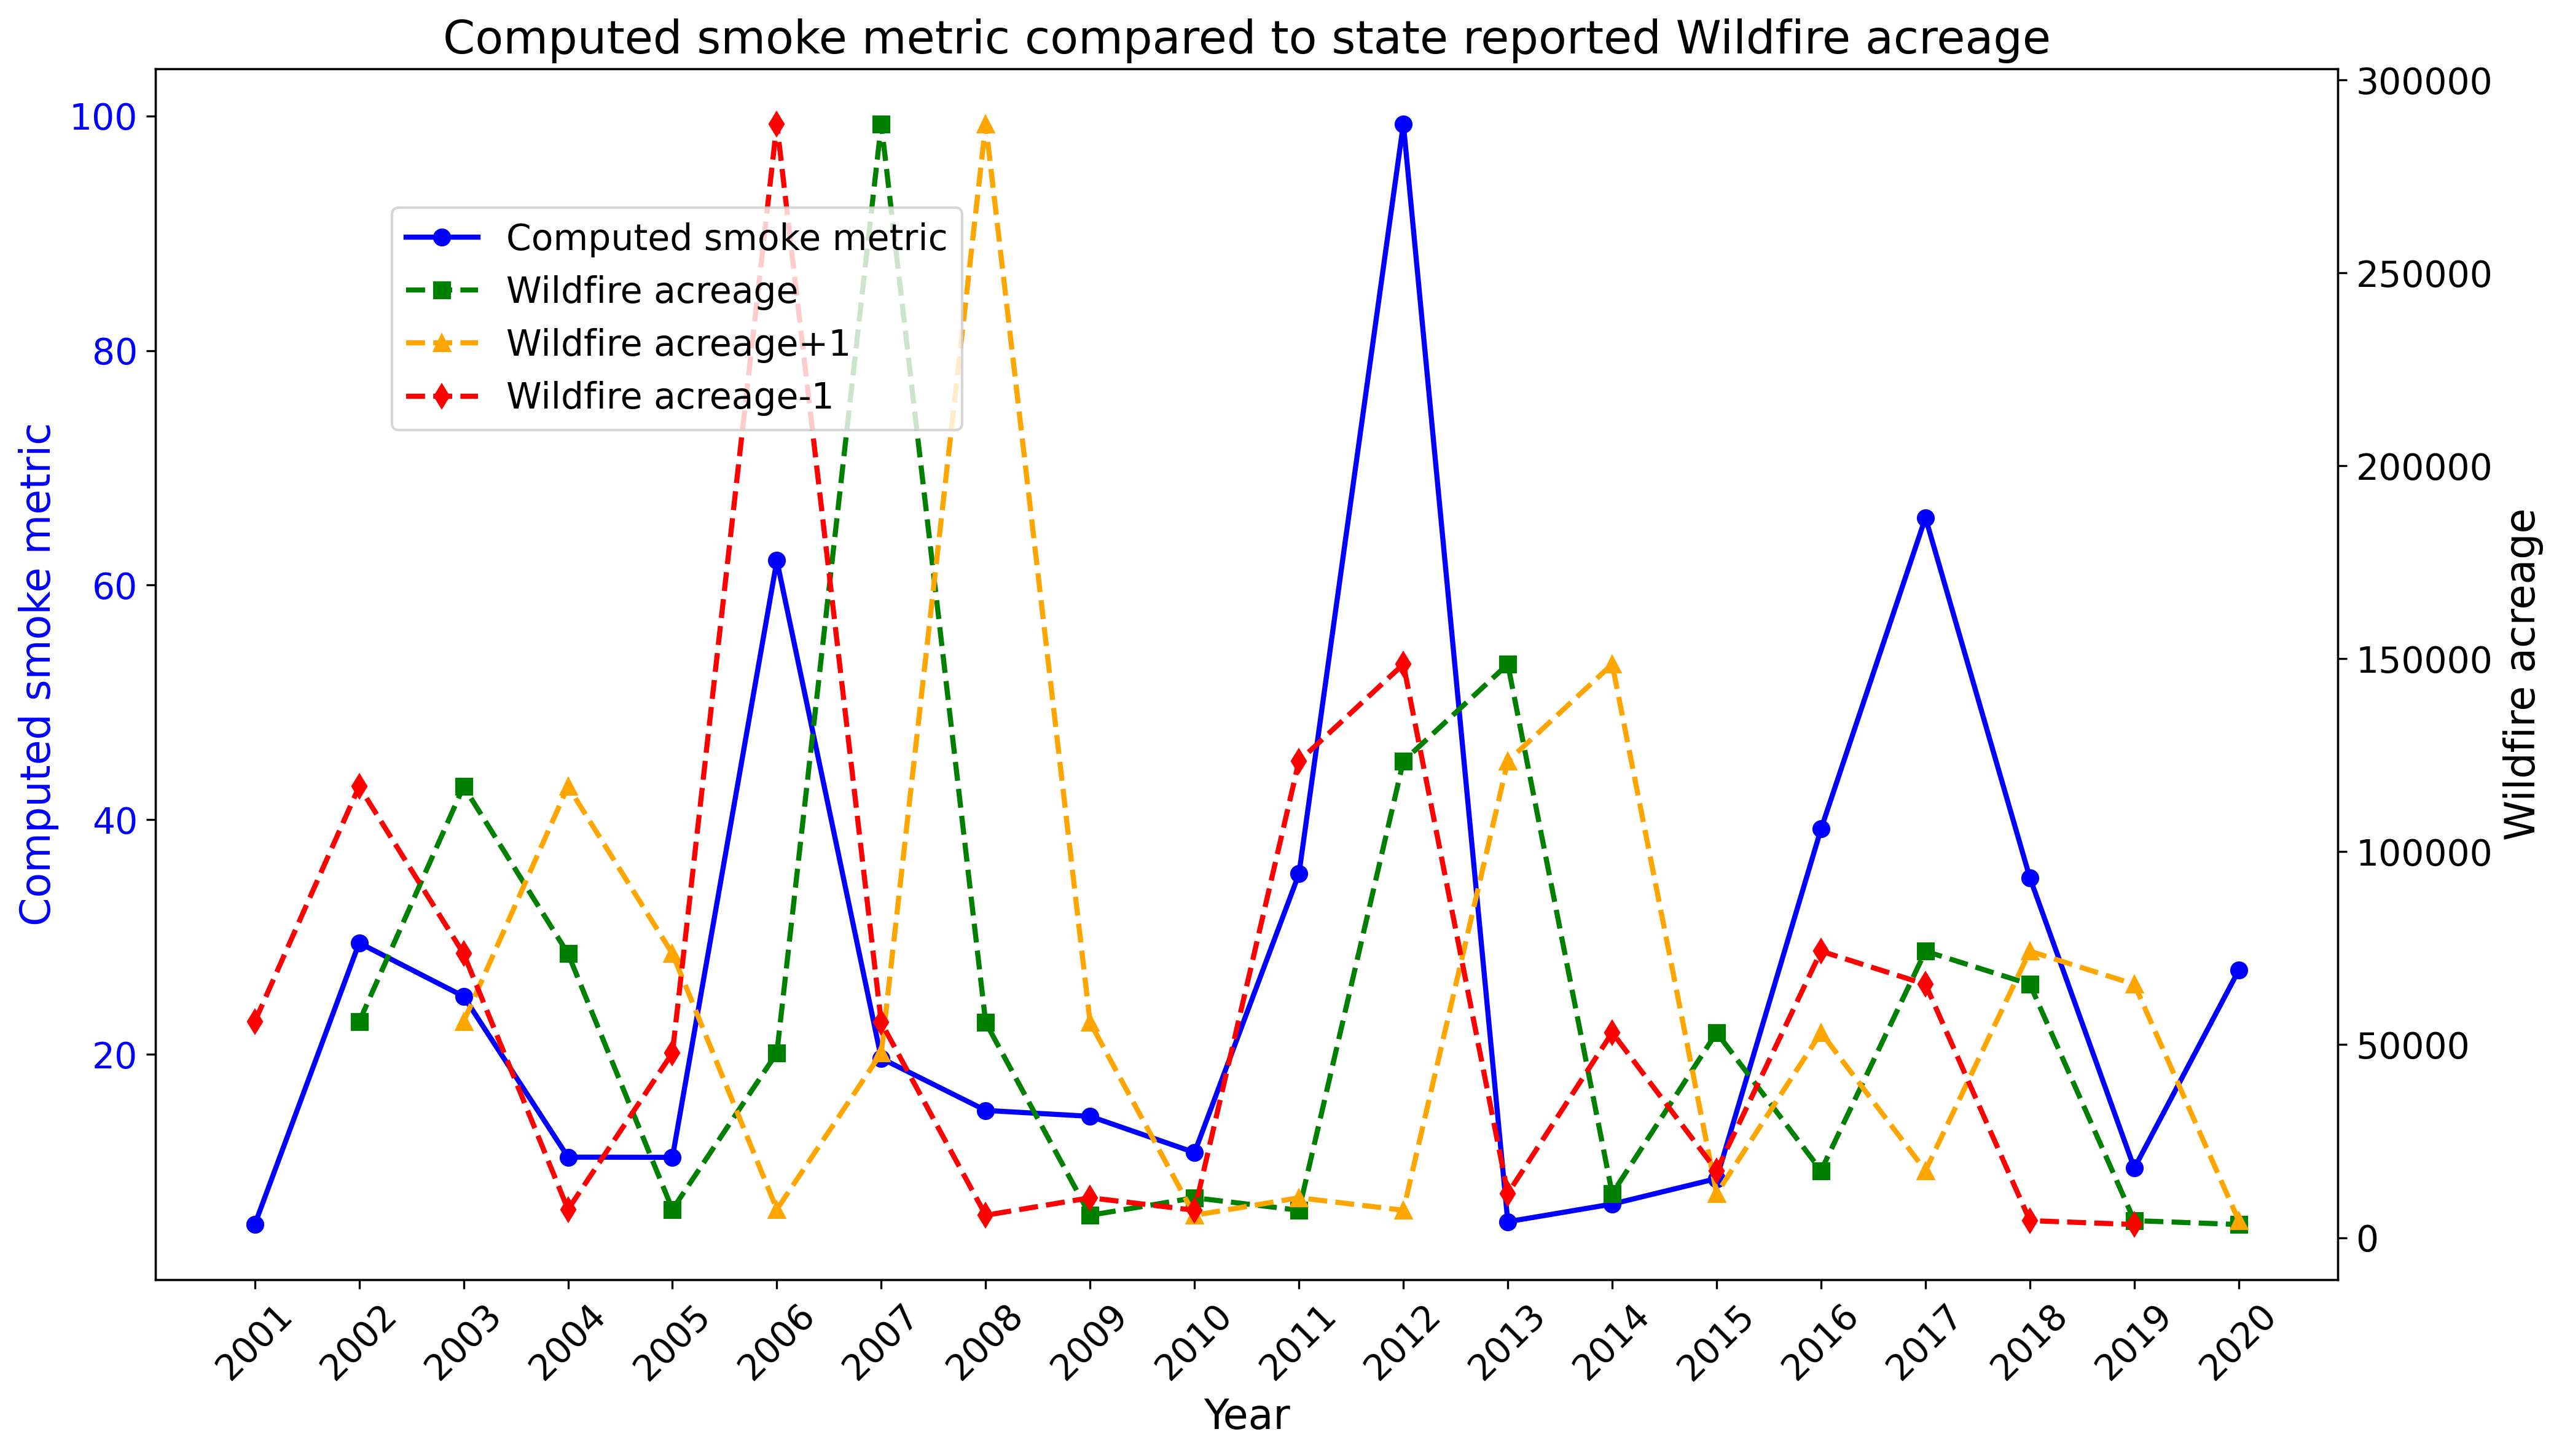

In [21]:
plot_smoke_metric_wildfire_acreage(wildfire_smoke_with_budget_info, "Computed smoke metric", "Wildfire acreage")

The cell below is intended to provide a more systematic way of determining which shift is best. It calculates the correlation between my smoke metric and the unshifted and shifted wildfire acreage data, finds the best shift, and then drops the unused shifts.

In [22]:
wildfire_smoke_with_budget_info = apply_shift(wildfire_smoke_with_budget_info, "Computed smoke metric", "Wildfire acreage", "Amount spent (2023 dollars)", True)

The Wildfire acreage with the best correlation with Computed smoke metric is 'Wildfire acreage-1' with a correlation of 0.67


The cell below plots my computed smoke metric with the shifted yearly wildfire suppression budget. 

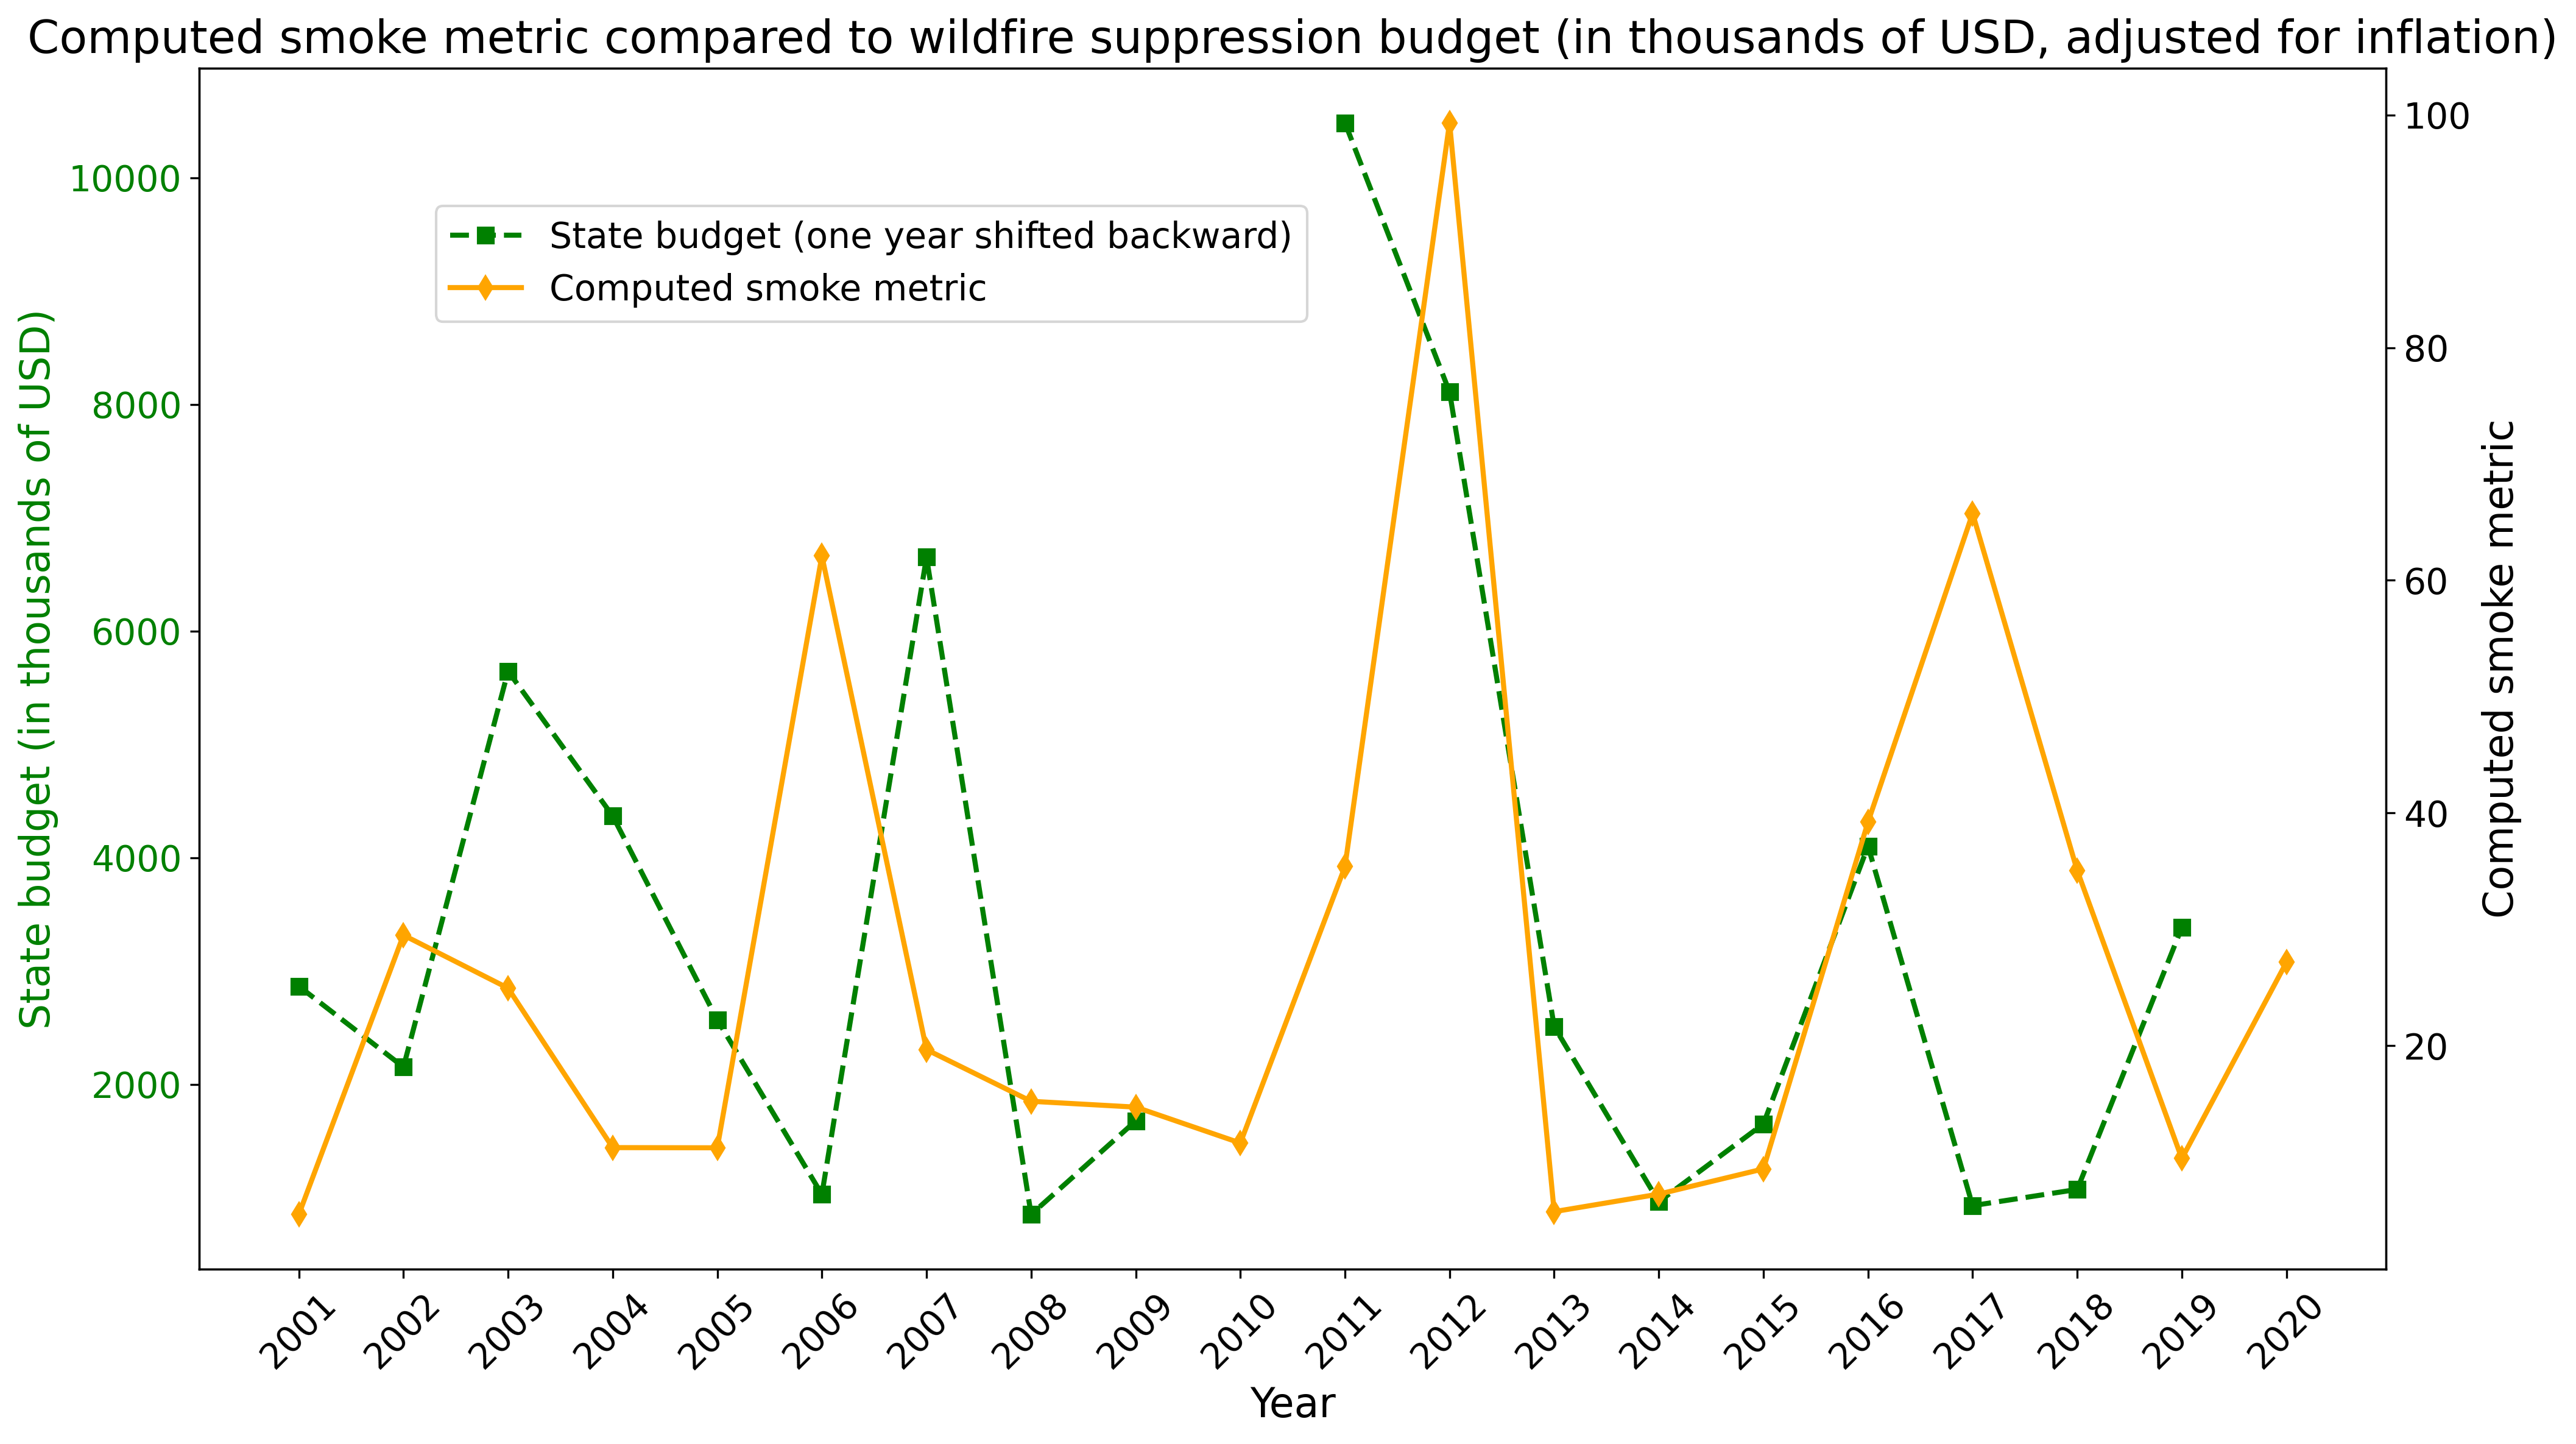

In [23]:
plot_smoke_metric_and_budget(wildfire_smoke_with_budget_info, "Computed smoke metric", "Amount spent (2023 dollars)-1")

The cell below recreates the same plot generated in smoke_impact_model_building.ipynb which shows the historical smoke metric and predicts it for the next 25 years. It also includes the confidence interval

The parameters for the Computed smoke metric model are: 
 const   -1265.289340
Year        0.642263
dtype: float64 




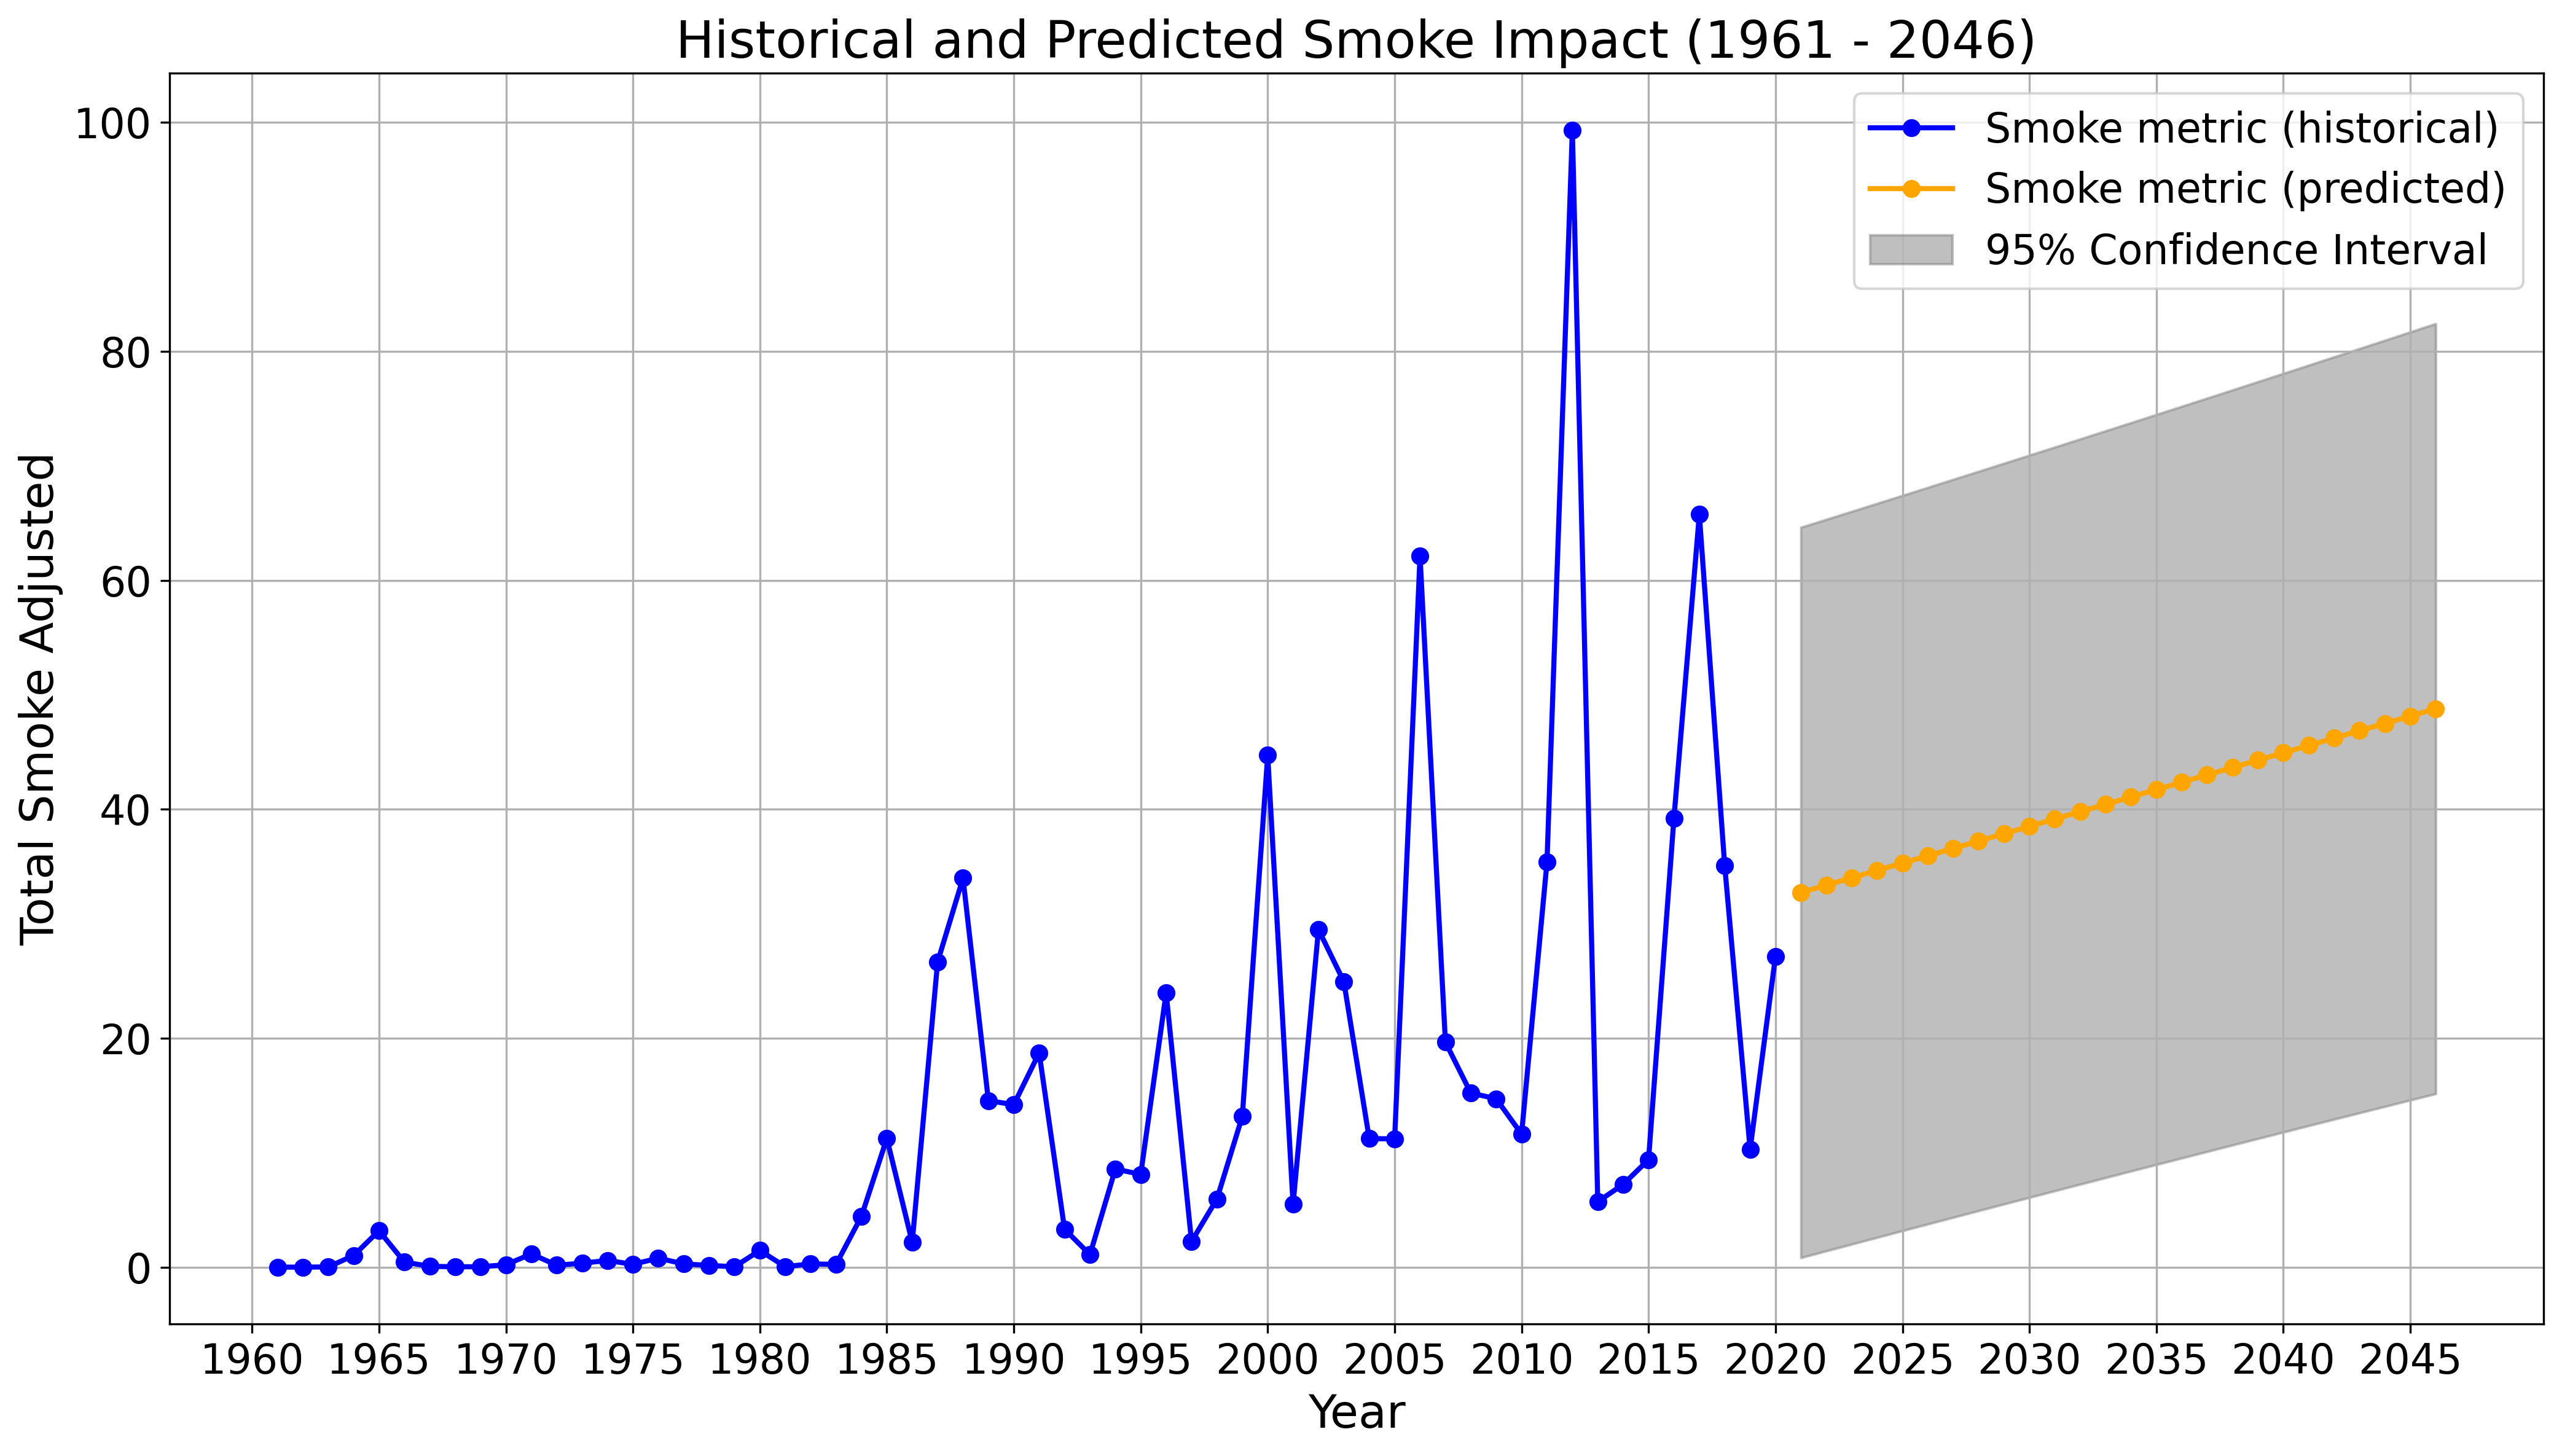

In [24]:
plot_smoke_model(smoke_dataframe, "Computed smoke metric", start_hist_year=1960, start_pred_year=2021, end_pred_year=2046, print_params=True)

The cell below plots the historical and predicted smoke metric and wildfire suppression budget. It includes the 95% confidence interval for the smoke metric. 

The parameters for the Computed smoke metric model are: 
 const   -1265.289340
Year        0.642263
dtype: float64 


The parameters for the Amount spent (2023 dollars)-1 model are: 
 const                    2532.486695
Computed smoke metric      30.780447
dtype: float64



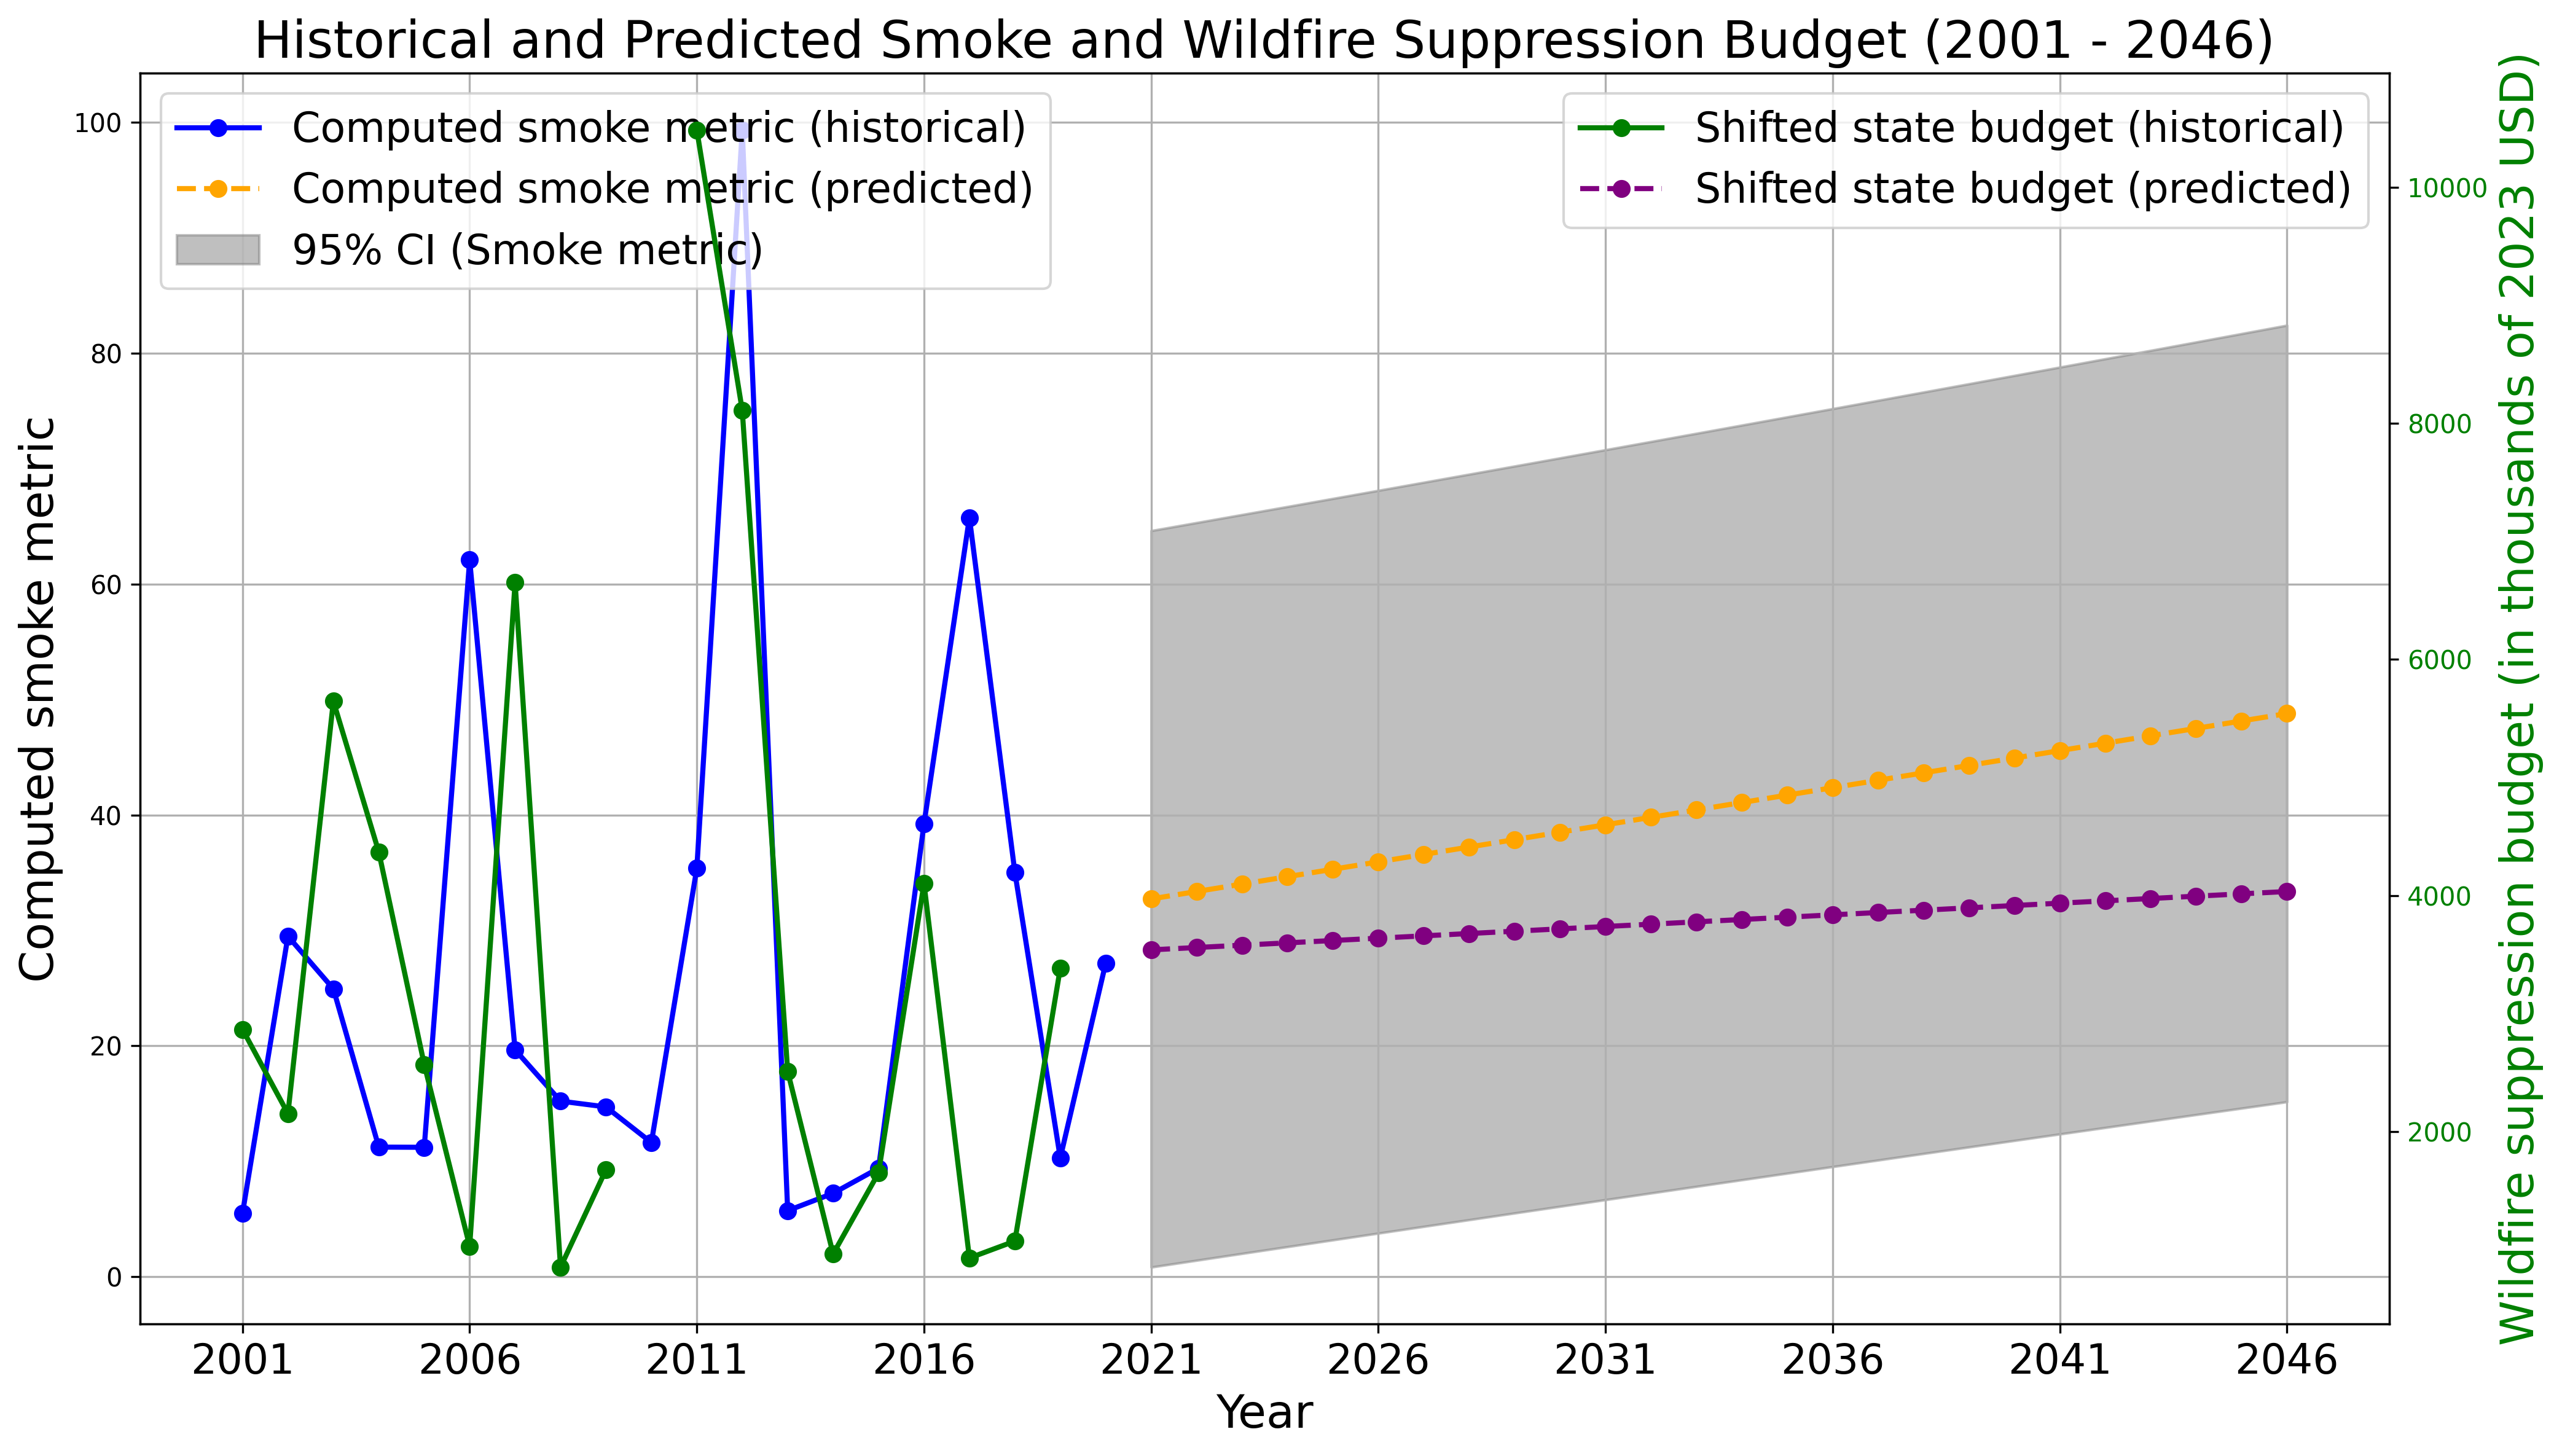

In [25]:
plot_budget_model(smoke_dataframe, wildfire_smoke_with_budget_info, "Computed smoke metric", "Amount spent (2023 dollars)-1", start_pred_year=2021, end_pred_year=2046, print_params=True)

The cell below plots the South Dakota wildfire information. Since both wildfire acreage and wildfire budgets are on the financial year, there's no shift needed. 

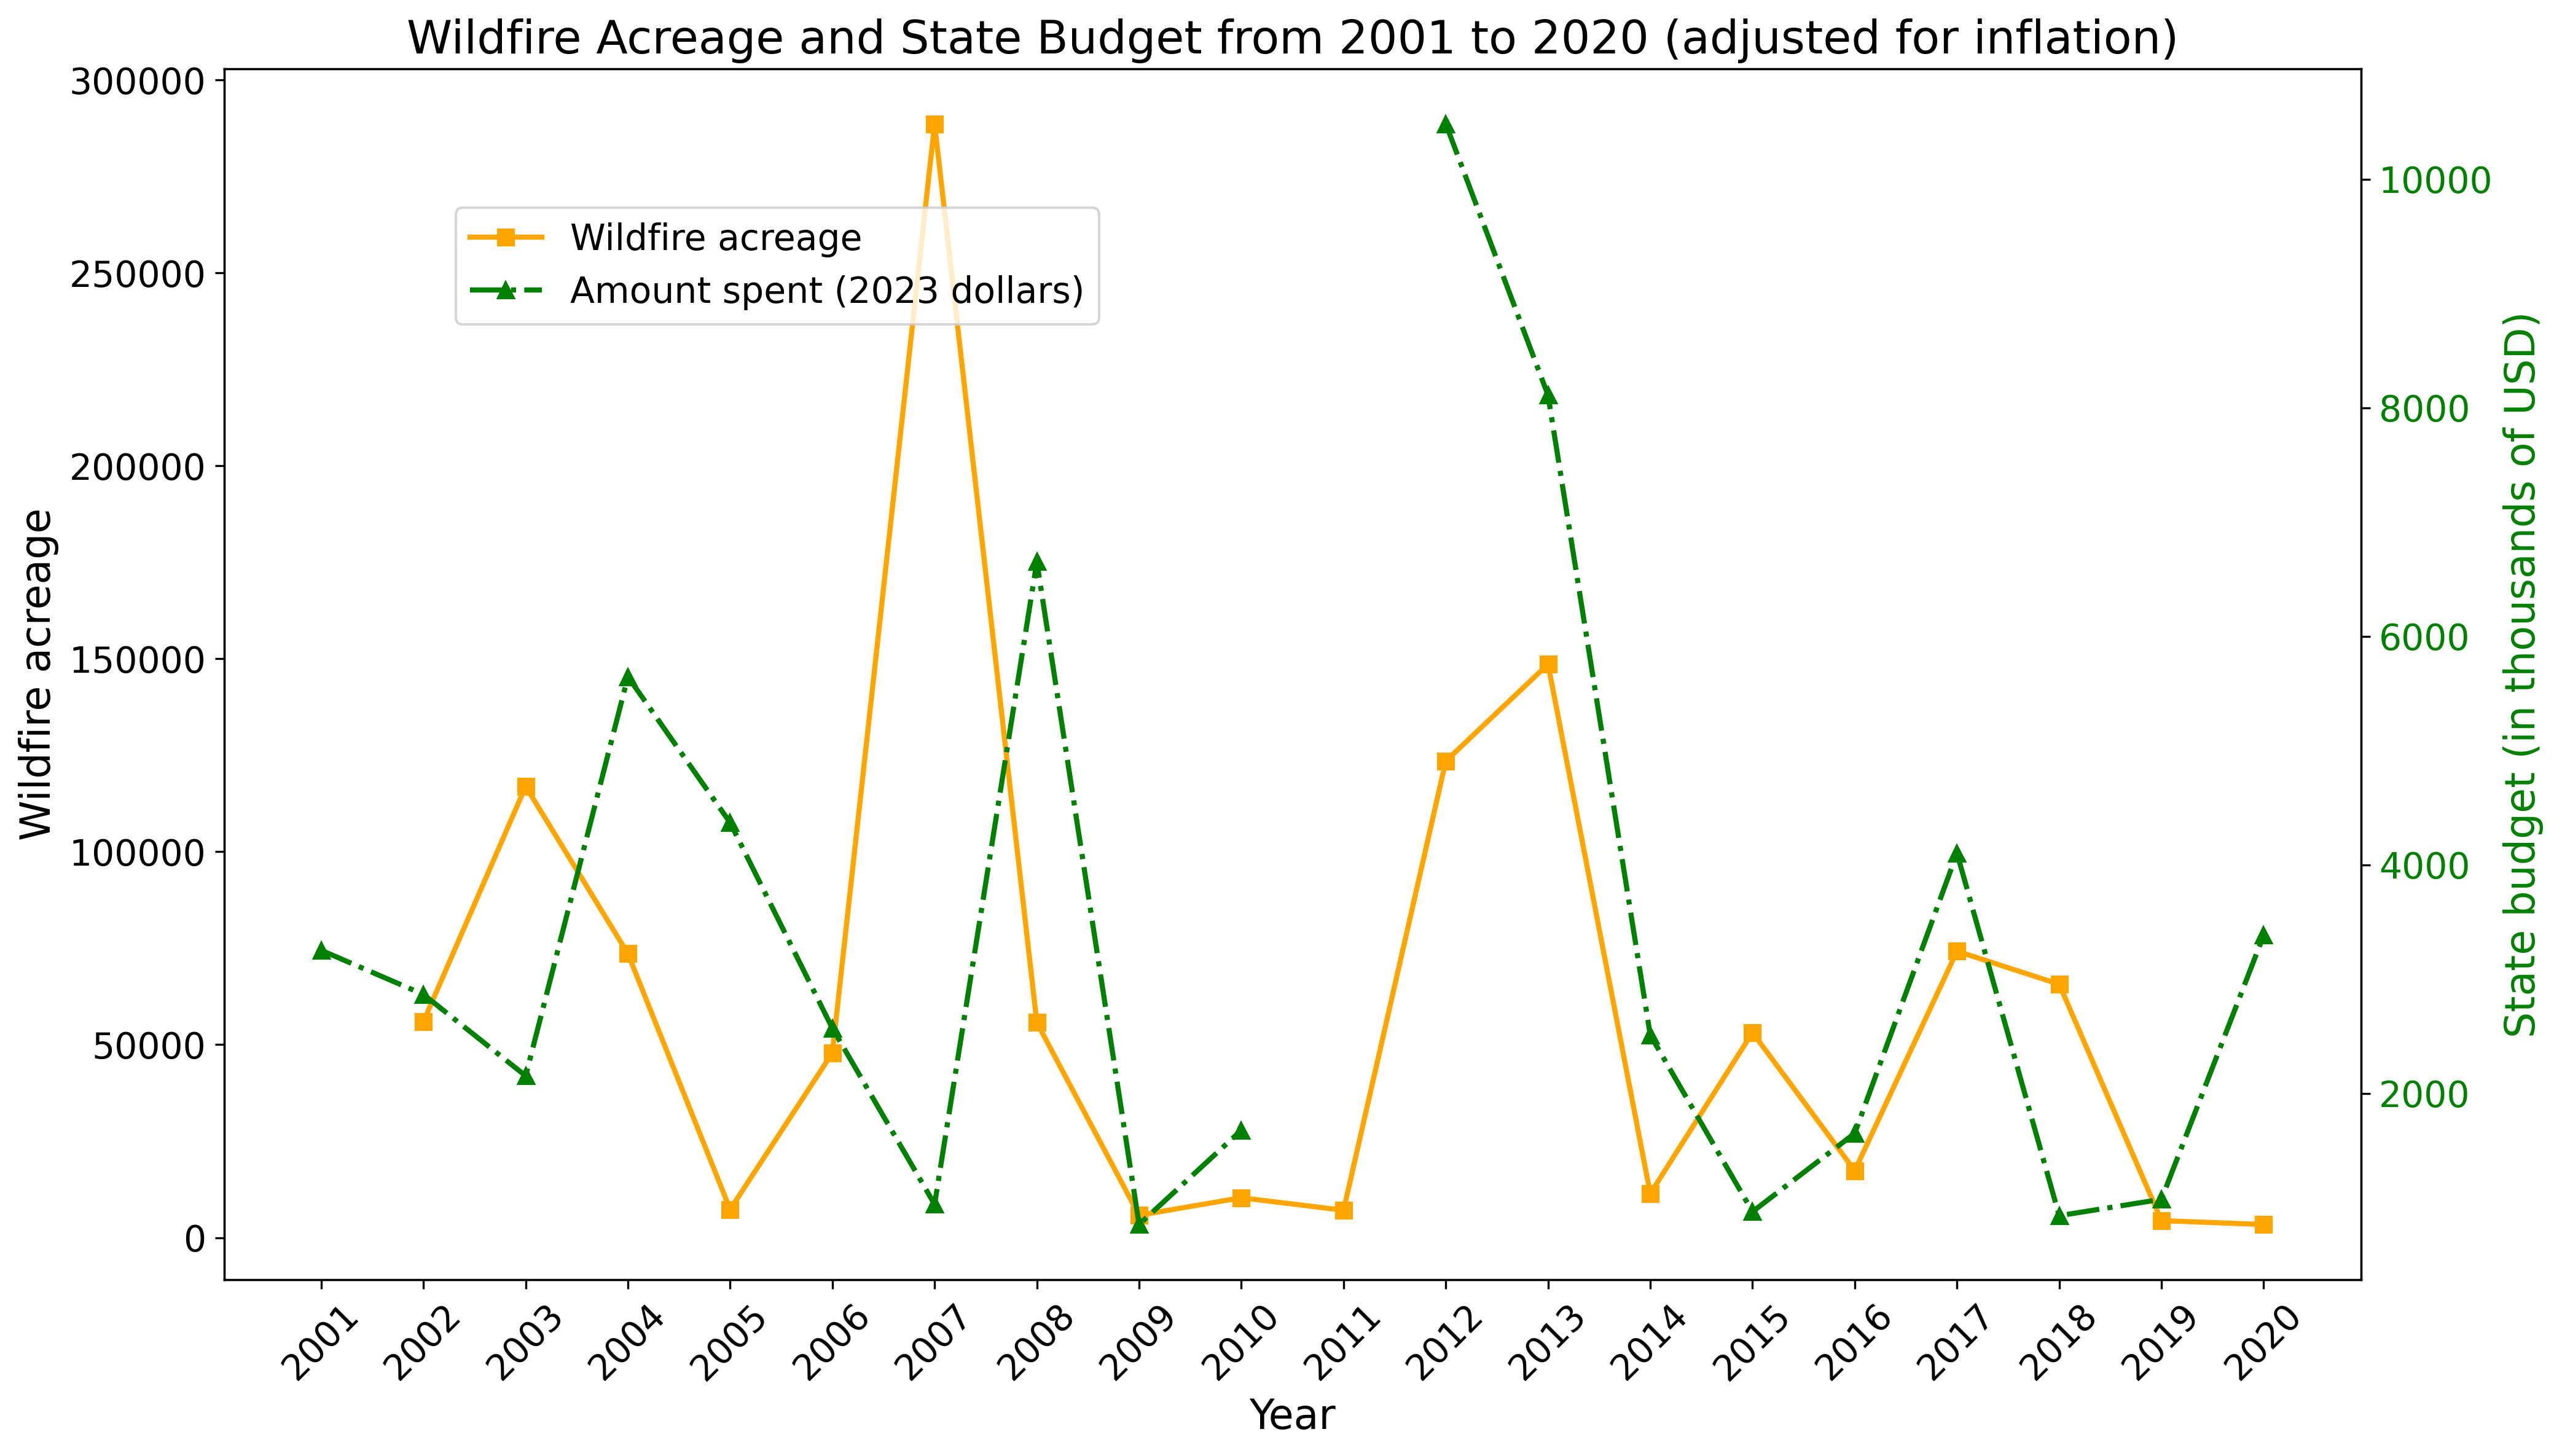

In [26]:
plot_acreage_and_budget(wildfire_smoke_with_budget_info, "Wildfire acreage", "Amount spent (2023 dollars)")

The cell below plots and prints the parameters for the models used to predict future wildfire acreage and state budget. 

The parameters for the Wildfire acreage model are: 
 const    6.609178e+06
Year    -3.255867e+03
dtype: float64 


The parameters for the Amount spent (2023 dollars) model are: 
 const               2852.540565
Wildfire acreage       0.008310
dtype: float64



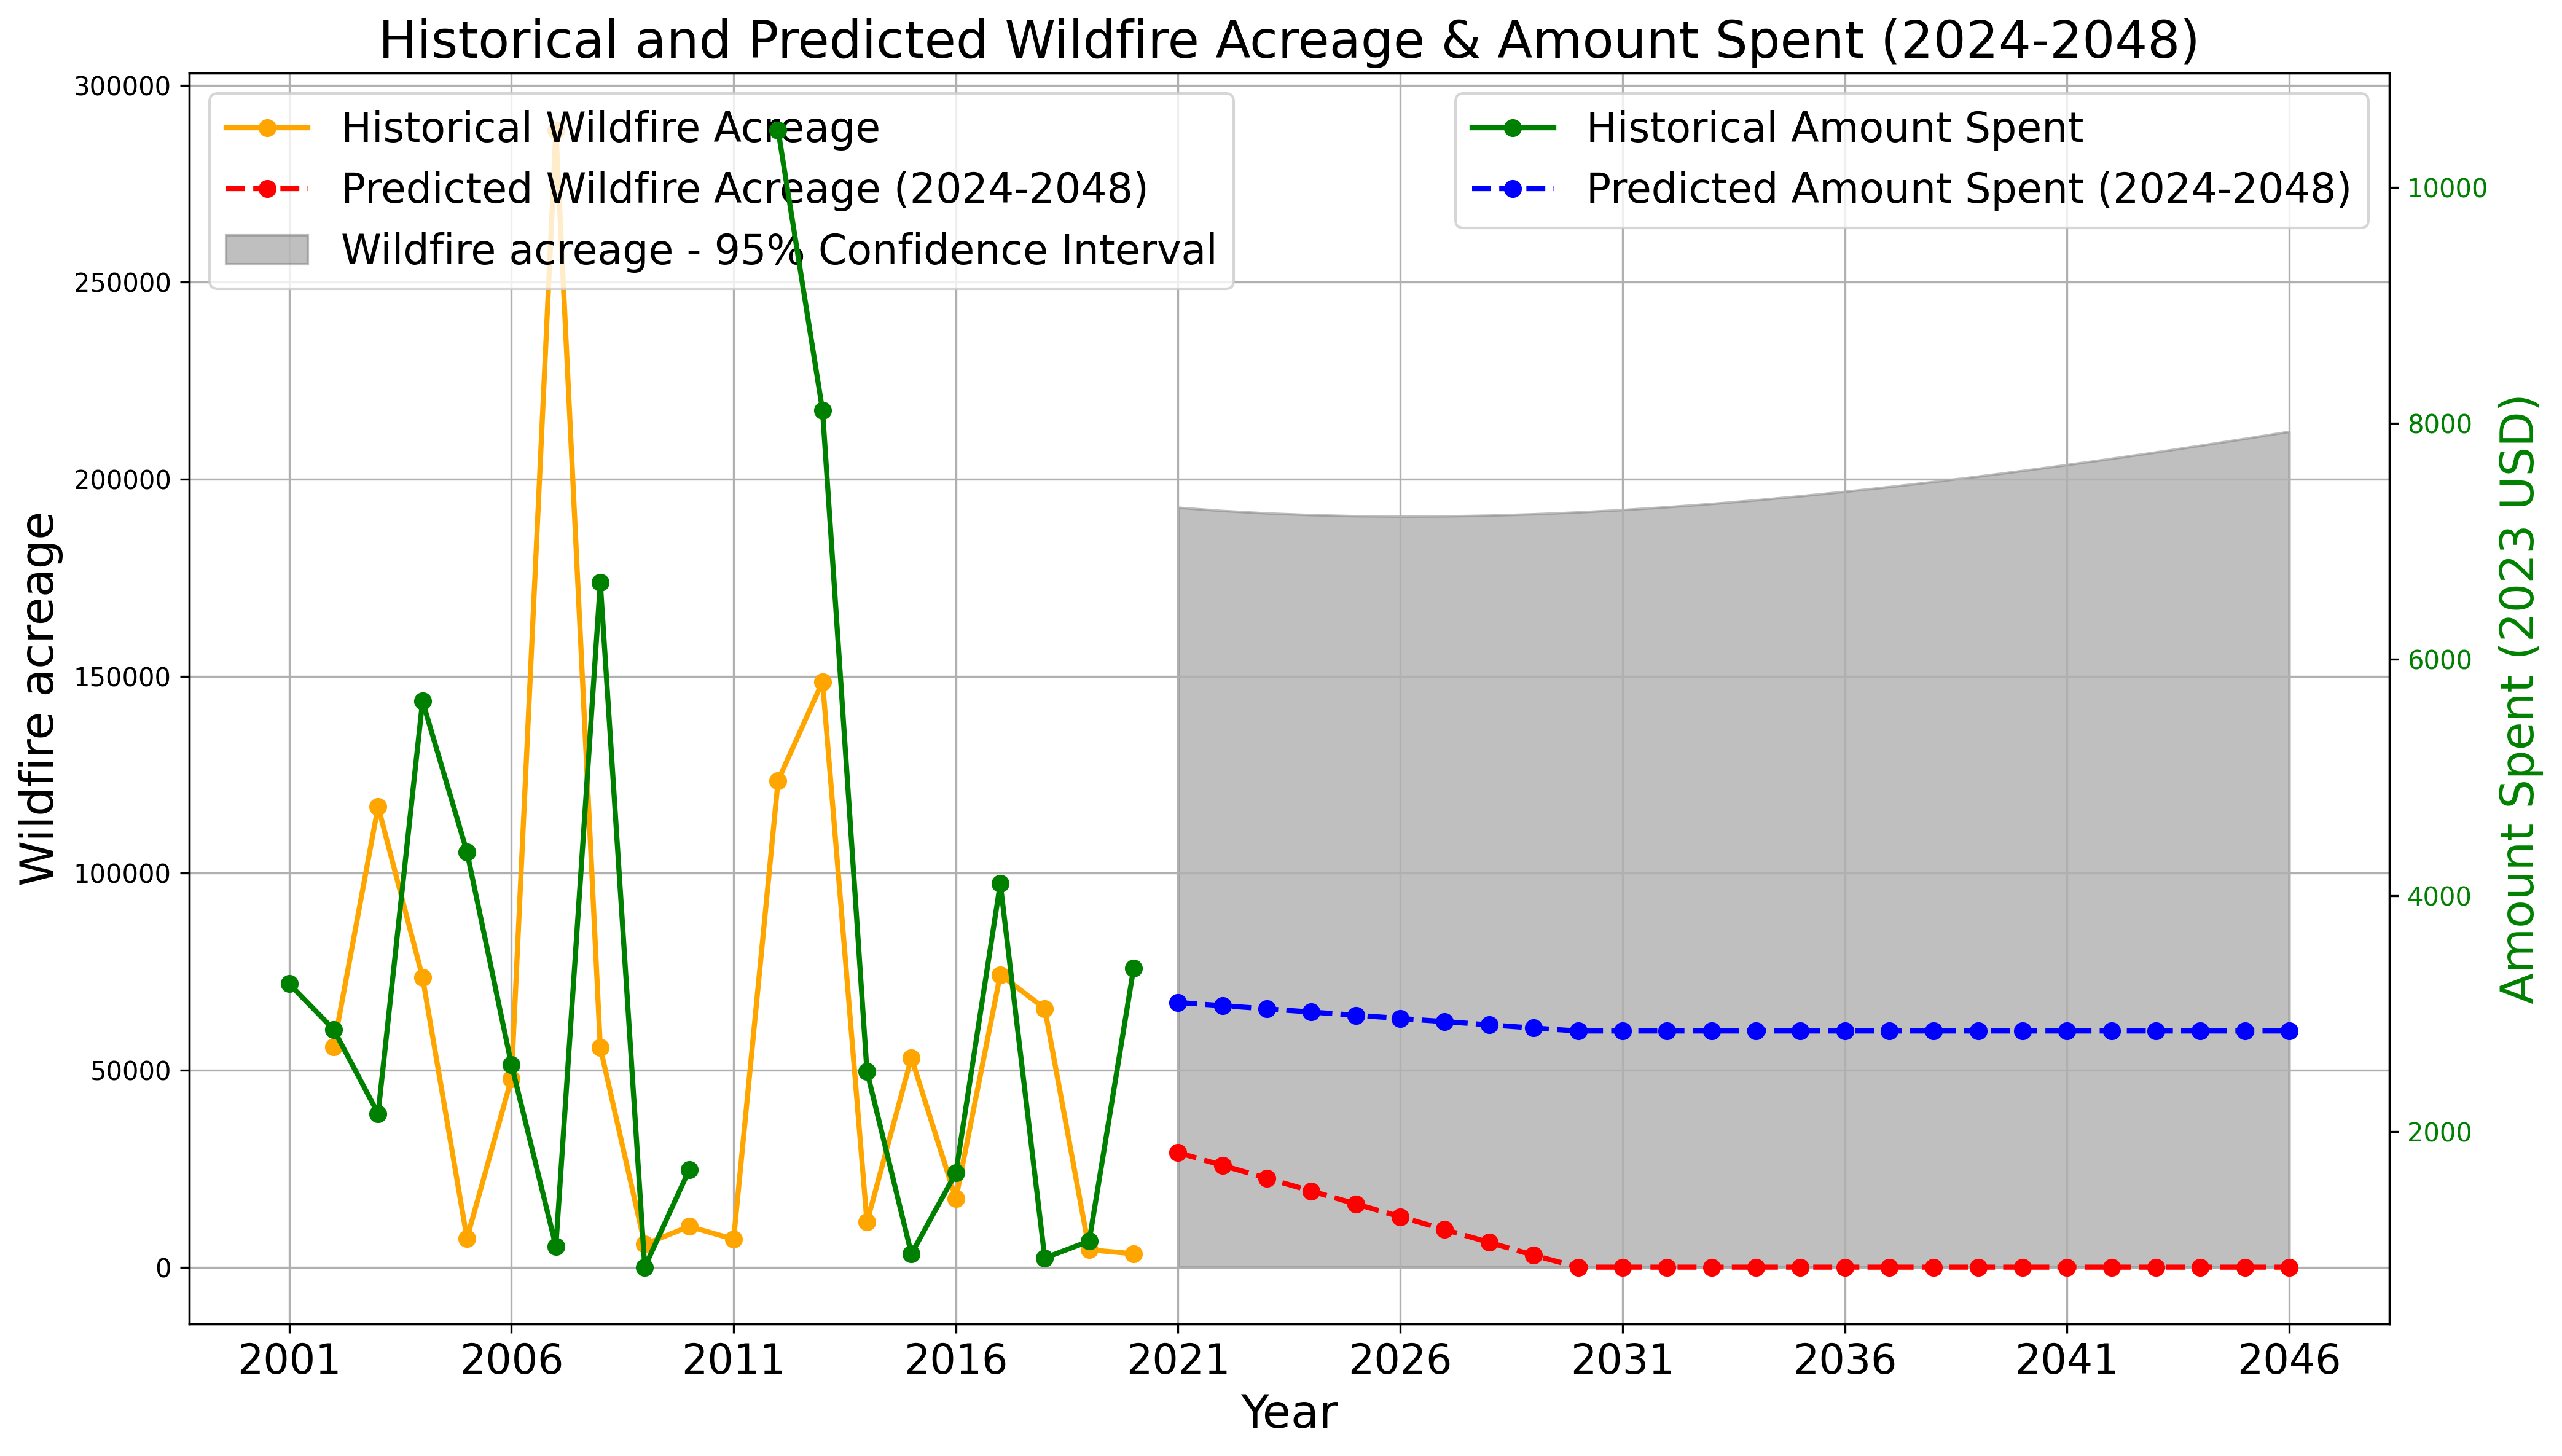

In [29]:
plot_future_acreage_and_budget(wildfire_smoke_with_budget_info, "Wildfire acreage", "Amount spent (2023 dollars)", 2021, 2046, print_params=True)